# Homework 4 - Classification Regression
### Poverty Level Classification using Costa Rican Demographic Data

In this notebook, I'll be building a classification-based regression model meant to predict the poverty levels of persons in the dataset. In the dataset, each observation is one person recorded in a Costa Rican demographics information. I'll be trying my hand at using classification models to glean insights about determinants of poverty, and whether poverty levels can be predicted to a reasonable degree.

### Accreditation:

The data used in this notebook comes from the [Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction) competition hosted by Kaggle.com. It was a real fun time and I'm glad they made the data available to the public!

I also thank the TA [Nelson Griffiths](https://github.com/ngriffiths13) for help with tricky lines of code, and lots of motivation. May he live long and prosper in the land.

In [1]:
!pip install imblearn seaborn

    100% |████████████████████████████████| 215kB 19.6MB/s ta 0:00:01
    100% |████████████████████████████████| 174kB 23.3MB/s ta 0:00:01


In [2]:
###Necessary Packages:

#The OGs:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
#Set Seaborn's Color Palette
sns.set_palette(sns.color_palette("muted", 30))

#Modeling Packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Validation Things
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

## Reading in, Visualizing Data

In this section, I'll go through the steps of reading in the data as well as visualizing it. This will be to get a sense of important relationships, or possible outliers. Throughout this section, I will reference the [data's documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) provided by Kaggle. It records all the variables in the datasets and how they are coded.

Kaggle submissions are formatted as two-column datasets with an identifier column (the "Id" variable from the test dataset) and a prediction column, predicted by training a model on the training dataset. To get started, I'll read in both datasets, define the target variable for later ("y"), and also define the identifier variable that I'll use later when making the final submission ("Id").

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
y = train_df.loc[(train_df['parentesco1']==1), 'Target']
Id = test_df.Id
train_df.shape[0]

9557

In [4]:
test_df.shape[0]

23856

In [5]:
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


What a blessing: the data read in correctly. Both datasets have several thousand observations with over 140 variables describing each one. 

The first thing I'll do is visualize some relationshps within the training dataset. I want to do this to just the training data as to not inform any of my modeling decisions on the testing dataset (no spoilers!). This step should be helpful in determining how variables should be coded for use in the prediction models as well as what variables may be associated with each other.

I'm gonna start with a few charts that tell us a few things about the target variable. For my first trick, a distribution of the target variable itself!

([<matplotlib.axis.XTick at 0x7f9d16d4dba8>,
 <a list of 4 Text xticklabel objects>)

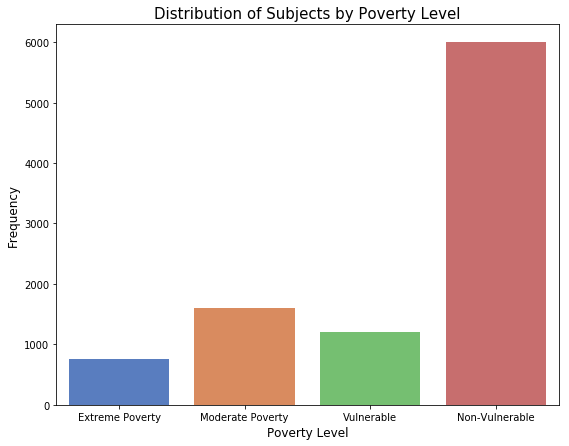

In [6]:
#Bar Chart of Target Variable (Poverty Level)
f, ax = plt.subplots(figsize=(9, 7))
sns.countplot(train_df.Target)
plt.title('Distribution of Subjects by Poverty Level', fontsize = 15)
plt.xlabel('Poverty Level', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])

It seems that in this dataset, only a relatively small number of people are in extreme poverty. Indeed, only about a third of the people in the dataset are at least vulnerable or are experiencing some kind of poverty. Classification-based regression will work better if people in different levels of income are distinct in other kinds of ways. I have access to education, technology, and other house-related data so I should be able to find some of those distinctions.

Let's have a look at how the target variable relates to, say, years of education. We might reasonably expect that there is a general upward trend in the variables; that is, that as years of education increases for observations, they are less-likely to be in "At Risk" poverty levels.

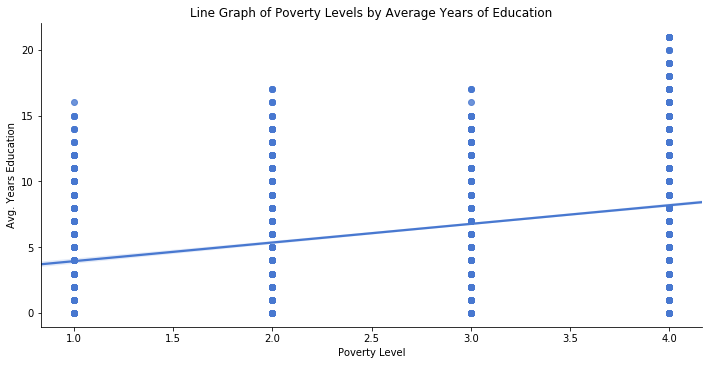

In [7]:
#Years of Education by Poverty Level
sns.lmplot(x = 'Target', y = 'escolari', data = train_df, aspect = 2)
plt.title('Line Graph of Poverty Levels by Average Years of Education')
plt.ylabel('Avg. Years Education')
plt.xlabel('Poverty Level')
plt.show()

This graph shows us mostly what we would expect: a general upward trend between education and affluence (the poverty level is measured entirely in income). 

There's actually another interesting takeaway here: different levels of income variance within education ranges. People who are in the "Not at Risk" level have education levels ranging from 0 to 20 years of education. The ranges are slightly more condensed among the more "At Risk" people. This will be somewhat helpful at least for a good portion of the testing data because if they have 16 to 20 years of education, it is very likely that they are in the Non-Vulnerable category. I suppose there might be some skew in this variable so I'll check on this later.

Now I'm going to look at a few boxplots. These may similarly help uncover quantifiable distinctions between poverty levels.

In [8]:
#Quick Function that Spits Out a Box Plot
def box_out(x):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.boxplot(x = 'Target', y = x, data = train_df)
    plt.xlabel('Poverty Level')

Number of Children Grouped by Income Levels


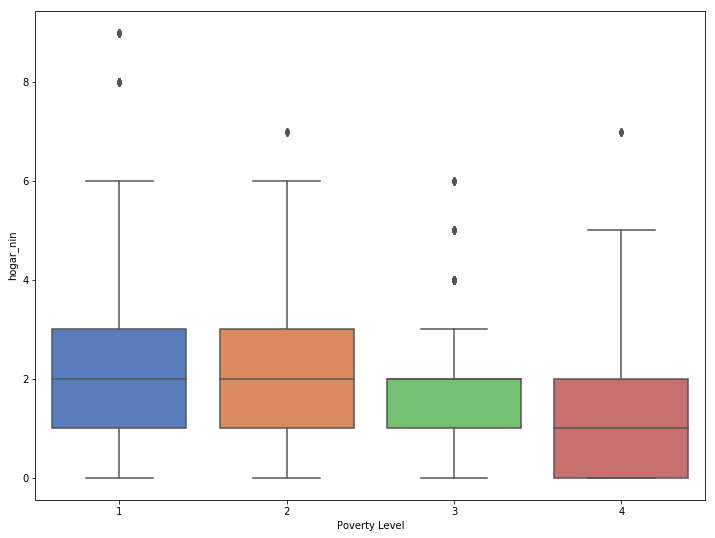

In [9]:
print("Number of Children Grouped by Income Levels")
box_out('hogar_nin')

Here, we see a slight trend of what we might expect. It happens that those who are non-vulnerable are slightly more likely to have fewer children. There are also a number of outlier observations of 8 or 9 children within the Extreme Poverty group. 

Monthly Mortgage Payments Grouped by Income Levels


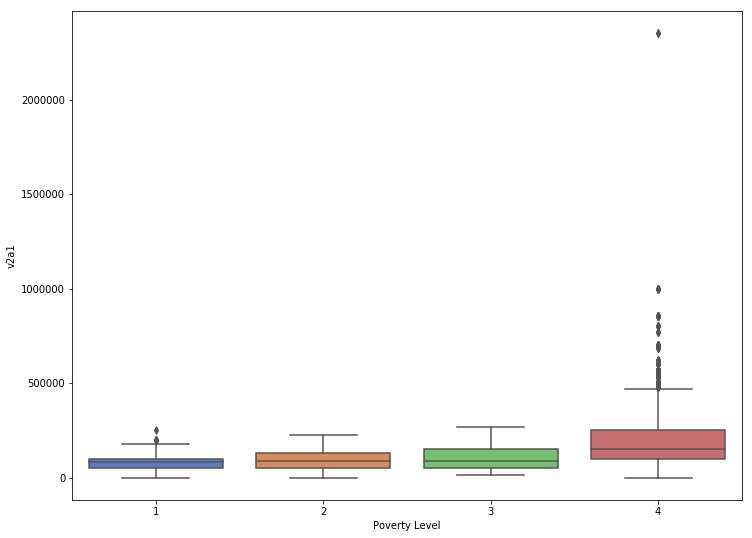

In [10]:
print("Monthly Mortgage Payments Grouped by Income Levels")
box_out('v2a1')

Still, we see pretty much what we'd expect: that families that make larger monthly rent payments are relatively more represented in the Non-Vulnerable category. It follows that if you are making bigger monthly rent payments, you have money to pay in the first place.

I'm going to look at some cross-tabulations of the poverty groups with house-related variables such as house materials and such.

In [11]:
print("Cross-Tabulation of Mosaic/Ceramic/Terrazo Floors by Income Group")
pd.crosstab(train_df['Target'], train_df['pisomoscer'])

Cross-Tabulation of Mosaic/Ceramic/Terrazo Floors by Income Group


pisomoscer,0,1
Target,,
1,403,352
2,808,789
3,471,738
4,1254,4742


These are informative but pretty intuitive results. Below, I have displayed the same information above but reported as proportions of people having this kind of flooring within their respective income groups:

    Group 1 (Extreme Poverty)  - 46.6%
    Group 2 (Moderate Poverty) - 49.4%
    Group 3 (At Risk)          - 61%
    Group 4 (Non-Vulnerable)   - 79.1%
    
Thus, this variable might be helpful at least in classifying the Non-Vulnerables.

In [12]:
print("Cross-Tabulation of Cement Floors by Income Group")
pd.crosstab(train_df['Target'], train_df['pisocemento'])

Cross-Tabulation of Cement Floors by Income Group


pisocemento,0,1
Target,,
1,470,285
2,1036,561
3,875,334
4,5046,950


And here are the proportions of households having cement floors by income group:

    Group 1 (Extreme Poverty)  - 37.7%
    Group 2 (Moderate Poverty) - 35.1%
    Group 3 (At Risk)          - 27.6%
    Group 4 (Non-Vulnerable)   - 15.8%
    
It is evidently the case that Non-Vulnerables are much less-likely to have cement floors. Indeed, they are nearly *half* as likely to have cement floorings as are those in the "At Risk" group, and around 40% as likely compared with those in extreme poverty.

So not many clear distinctions between income groups are immediately visible from my visualizations. Hopefully, the cleaning and feature engineering stage can help turn messy information into more coherent data that helps in prediction modeling.

## Data Cleaning and Feature Engineering

In this stage, I will start with the data cleaning and the construction of new variables. Data cleaning will here entail the imputing of missing values with appropriate information, and fixing of mis-coded variables or variables that should be coded in a different way. Feature Engineering will be creating new variables that make use of information already in the datasets.

### Cleaning

Cleaning will be done to both datasets together, so I combine them with the following code:

In [13]:
#Combining Datasets
ntrain = train_df.shape[0]
full_df = pd.concat((train_df.drop('Target', axis = 1), test_df)).reset_index(drop = True)
full_df = full_df.drop('Id', axis = 1)

In [14]:
full_df.shape

(33413, 141)

Let's look at some missing values. The following code sorts all the variables in the dataset by the number of missing values that variable has:

In [15]:
full_df.isna().sum().sort_values(ascending = False)

rez_esc            27581
v18q1              25468
v2a1               24263
meaneduc              36
SQBmeaned             36
v14a                   0
sanitario6             0
techocane              0
techootro              0
cielorazo              0
abastaguadentro        0
abastaguafuera         0
abastaguano            0
public                 0
planpri                0
noelec                 0
coopele                0
sanitario1             0
sanitario2             0
sanitario3             0
sanitario5             0
energcocinar1          0
refrig                 0
energcocinar2          0
energcocinar3          0
energcocinar4          0
elimbasu1              0
elimbasu2              0
elimbasu3              0
elimbasu4              0
                   ...  
parentesco2            0
parentesco1            0
estadocivil7           0
estadocivil6           0
estadocivil4           0
instlevel2             0
estadocivil3           0
estadocivil2           0
estadocivil1           0


Well that is convenient: all of five variables in the combined dataset even have missing values at all. I list them below:

**rez_esc** - Years behind in school

**v18q1** - Number of tablets in the household

**v2a1** - Monthly rent payment

**meaneduc** - Average years of education for adults in the household

**SQBmeaned** - Average years of education for adults squared

First, I'll investigate the "Number of Tablets in the House" variable:

In [16]:
full_df['v18q1'].head(10)

0    NaN
1    1.0
2    NaN
3    1.0
4    1.0
5    1.0
6    1.0
7    NaN
8    NaN
9    NaN
Name: v18q1, dtype: float64

In [17]:
full_df['v18q1'].value_counts()

1.0    5883
2.0    1449
3.0     447
4.0     125
5.0      31
6.0      10
Name: v18q1, dtype: int64

It's probably the case that a missing value denotes not having any tablets at all. There happens to be a dummy variable that records owning at least one tablet, and its zero values seem to correspond with missing values of the categorical variable.

In [18]:
full_df['v18q'].head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    0
8    0
9    0
Name: v18q, dtype: int64

In [19]:
full_df.v18q1 = full_df.v18q1.fillna(0)

I'll now look at the mean education variable. The documentation says it's the average level of education for adults (presumably) in the household so there's no clear indicator for why this might be missing. There are 36 of these values - I'll take a look at all of these rows:

In [20]:
full_df.loc[(full_df['SQBmeaned'].isnull()) & (full_df['meaneduc'].isnull())]

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
1291,NaN,0,7,0,1,1,0,0.0,0,0,...,18,100,324,1,0,1,0.040000,64.0,NaN,324
1840,110000.0,0,1,0,1,1,0,0.0,0,1,...,18,36,324,4,16,4,4.000000,64.0,NaN,324
1841,110000.0,0,1,0,1,1,0,0.0,0,1,...,18,16,324,4,16,4,4.000000,64.0,NaN,324
2049,180000.0,0,3,0,1,1,0,0.0,0,2,...,19,144,361,4,144,4,1.000000,64.0,NaN,361
2050,180000.0,0,3,0,1,1,0,0.0,0,2,...,19,144,361,4,144,4,1.000000,64.0,NaN,361
9561,175000.0,0,4,0,1,1,1,1.0,0,0,...,18,121,324,1,0,1,0.250000,64.0,NaN,324
10092,399378.0,0,6,0,1,0,1,3.0,0,0,...,18,121,324,1,0,1,1.000000,64.0,NaN,324
10093,180000.0,0,4,0,1,1,0,0.0,0,0,...,19,144,361,4,0,4,1.000000,64.0,NaN,361
10094,180000.0,0,4,0,1,1,0,0.0,0,0,...,19,144,361,4,0,4,1.000000,64.0,NaN,361
12169,100000.0,0,2,0,1,1,0,0.0,0,1,...,19,64,361,4,64,4,4.000000,64.0,NaN,361


Though I can't see the variable in question, these are all the columns where the Mean Education variable is missing. All missing values of this variable similarly correspond to missing Education Squared variable values. No clear indicators stick out to me as to why any value would be missing - their rent payments, house characteristics, and household demographics all seem to vary widely. 

To deal with these, I'll just impute the median value grouped by years of schooling. It's reasonable to think that the distributions of years of schooling are similar within cohorts of years of schooling.

In [21]:
#Imputing Missing "Mean Education" Values with Median of "Years of Schooling" Group
full_df['meaneduc'] = full_df.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))

#Filling in "Mean Education Squared"
full_df['SQBmeaned'] = (full_df.meaneduc)**2

I'm not sure to begin with the "Years Behind" variable, but I'll start with a cross-tabulation. Hopefully, this can give me a hint as to whether the the missing values are overrepresented in certain age groups:

In [22]:
pd.crosstab(full_df['rez_esc'], full_df['age'])

age,7,8,9,10,11,12,13,14,15,16,17
rez_esc,,,,,,,,,,,
0.0,478,512,480,456,374,433,454,377,329,326,255
1.0,0,18,33,58,55,69,60,97,113,119,106
2.0,0,0,2,5,12,21,21,24,76,91,84
3.0,0,0,0,4,3,6,5,6,8,75,67
4.0,0,0,0,0,1,1,1,0,1,7,69
5.0,0,0,0,0,0,5,3,5,4,9,13
99.0,0,1,0,0,0,0,0,0,0,0,0


Shoot: missing values don't seem to appear on this chart. However, this chart does show that the variable seems only to apply to people in the 7 to 17 age range. This makes sense - in order to be behind in school, you have to be in school in the first place; namely, in *public school* where being behind is even a concern. The first part of dealing with this, then, will just be filling in zeros for those outside the relevant age group.

There also appears to be a pesky 99. I imagine this was supposed to be a missing value? I'll recode this before I impute the missing values.

In [23]:
#Recode "Years Behind" as Zero for Not-In-School Observations
full_df.loc[((full_df['age'] >= 17) | (full_df['age'] < 7)) & (full_df['rez_esc'].isnull()), 'rez_esc'] = 0

#Fix Pesky 99
full_df.loc[(full_df['rez_esc'] == 99)] = 0

#Checks remaining Missing Values
full_df['rez_esc'].isna().sum()

5

Only five missing values remain, but I'll deal with them responsibly. I reckon the most appropriate fix would be to impute missing values with the median "Years Behind" value of that observation's Mean Education group within the training data. Of all the groups in the data, I imagine that average household education affects anyone's "Years Behind" the most (actually, it is probably income but predicting missing values based on the Target could cause an endogeneity problem). My reasoning is that assuming parents are the principal deciders of who goes to school and who doesn't, their lack of recognizing the benefits of their education itself (low levels of "Mean Education") may correspond to unwillingness to support their children through school (higher levels of "Years Behind" values). 

In [24]:
#Imputes Missing "Years Behind" Values with Median of "Mean Education"
full_df['rez_esc'] = full_df.groupby('meaneduc')['rez_esc'].transform(lambda x: x.fillna(x.median()))

For the last missing variable, Rent Payments, I'll similarly make a cross-tabulation to see if higher rates of missing values are associated with different home ownership statuses. I'll do this using a binary flag showing whether the variable in question (Rent Payments) is missing, and tabulate this with different specifications of home ownership.

In [25]:
#Creates Binary Flag for Missing Values
full_df['missing_rent'] = 0
full_df.loc[(full_df.v2a1.isnull()), 'missing_rent'] = 1

#Creates an Ownership Status Variable Made of Condensed Dummies
full_df['own_status'] = "NaN"
full_df.loc[(full_df.tipovivi1 == 1), 'own_status'] = "Own, Fully Paid"
full_df.loc[(full_df.tipovivi2 == 1), 'own_status'] = "Own, Paying in Installments"
full_df.loc[(full_df.tipovivi3 == 1), 'own_status'] = "Rented"
full_df.loc[(full_df.tipovivi4 == 1), 'own_status'] = "Precarious"
full_df.loc[(full_df.tipovivi5 == 1), 'own_status'] = "Other (Assigned, Borrowed)"

#Cross-Tab
pd.crosstab(full_df['missing_rent'], full_df['own_status'])

own_status,NaN,"Other (Assigned, Borrowed)","Own, Fully Paid","Own, Paying in Installments",Precarious,Rented
missing_rent,,,,,,
0,1,0,0,3497,0,5652
1,0,2822,20844,0,597,0


Well that is a nice find: most of the missing values of rent payments correspond to households which own and have fully paid off their houses. There's no need to worry about their missing payments and we can just impute these with zeros. Of the 27,579 originally identified missing values, this accounts for about 76% of the missing values in this variable.

For the rest of the missing values (there are about 3,500) of them remaining, I'll just impute the median value for that dataset (whether it's from the training or testing dataset). The code involves grouping observations by the "Head of Household" marker variable, but this still imputes the median of the appropriate dataset without using information from the other dataset.

In [26]:
#Replace Observations with Paid-Off Houses as Zero for Rent Payment Variable
full_df.loc[(full_df.tipovivi1 == 1, 'v2a1')] = 0

#Fill in Other Missing Values with Median Using Training Data for Heads of Households
full_df['v2a1'] = full_df.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

In [27]:
full_df.isna().any().sum()

0

In [28]:
#Drop Variables Generated for Cross-Tab
full_df = full_df.drop('own_status', axis=1)
full_df = full_df.drop('missing_rent', axis=1)

### Categorical Variables

In this dataset, I have not yet had a look at categorical variables if there are any that need to be dealt with. The code below returns them.

In [29]:
full_df.select_dtypes(include = 'object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


Don't be alarmed - the "Dependency", "Edjefe (Male Head of Household Years of Education)", and "Edjefa (Female Head of Household Years of Education)" are all actually ordinal. It just happens that "1" and "0" for these variables were left as "yes" and "no" respectively. All that needs to be done for them is making that change. 

The other variable, "idhogar" is a family identifier that won't actually be used for modeling. I'm just going to drop this variable.

In [30]:
#Turn "Yes" and "No" into "1" and "0", Respectively
full_df.loc[(full_df['dependency'] == 'yes'), 'dependency']=1
full_df.loc[(full_df['dependency'] == 'no'), 'dependency']=0
full_df['dependency'] = full_df['dependency'].apply(pd.to_numeric)

full_df.loc[(full_df['edjefe'] == 'yes'), 'edjefe']=1
full_df.loc[(full_df['edjefe'] == 'no'), 'edjefe']=0
full_df['edjefe'] = full_df['edjefe'].apply(pd.to_numeric)

full_df.loc[(full_df['edjefa'] == 'yes'), 'edjefa']=1
full_df.loc[(full_df['edjefa'] == 'no'), 'edjefa']=0
full_df['edjefa'] = full_df['edjefa'].apply(pd.to_numeric)

There is still a lot of categorical-based information in this dataset including housing materials, house region, education levels, and so on. Fortunately, this data is already all coded numerically so no changes need to be made to those variables.

### Feature Engineering

In this section, I discuss the rationalizations and show the code for creating new and exciting variables using the data on hand. The purpose of this step is to use information we already have to create new variables that might be better predictors of the target variable.

I'll create two new variables based on the makeup of each household: one recording the household's percentage of youth-aged persons, and another recording the same percentage of old persons.

I'll create two technology-based variables: one that records the number of technological devices per capita (I make the assumption that technological devices bring about the same marginal utility in use), and one that records a rough scaling of housing quality. This scale increases by one or two points for selected values of housing material variables, especially such variables that record quality of materials used.

In [31]:
#Household Youth Prop.
full_df['youth_prop'] = full_df['hogar_nin'] / full_df['hogar_total']

#Household Seniority Prop.
full_df['sr_prop'] = full_df['hogar_mayor'] / full_df['hogar_total']

#Household Tech Devices Per Capita
full_df['tech_per_cap'] = (full_df['v18q'] 
                        + full_df['computer']
                        + full_df['qmobilephone'] 
                        + full_df['television']) / full_df['tamviv']

#Household Quality Score
full_df['house_quality'] = (full_df['cielorazo']
                         + full_df['epared2'] 
                         + 2*full_df['epared2']
                         + full_df['etecho2']
                         + 2*full_df['etecho3']
                         + full_df['eviv2']
                         + 2*full_df['eviv3'])

If any of these variables turn out to be useful in the creation of later prediction models, the results will show it.

## Creating Prediction Models

Now that the datasets have been sufficiently cleaned and new variables have been created, I'm ready to start trying out some models on the data. I'll be validating models using a train-test-split method and will define a function that tests models based on their cross-validation f1-macro scores. F1-macro scores are computed by taking f1 scores and weighting each class equally to compute an average f1 score. 

There are a slew of modeling techniques available to use for classification problems. Below, I list several of them and describe how each goes about the classification problem. There are even more available than those I list here, but I don't have access to those on this version of Jupyter Notebook... Later on, I'll evaluate which ones did the best, and take those on to the hyper-parameter tuning stage. The descriptions listed here are all taken from each classifier's individual documentation page from the Scikit Learn website.

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): A classifier algorithm based on Random Forest, or multiple decision trees. It fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Samples are drawn wirth replacement if bootstrap=True, which is the default setting.

[K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): K-Nearest Neighbors classifies observations by defining 1) "k" amount of "neighbor" observations near the target, 2) a distance between the target and its neighbors (usually euclidian), and 3) takes the average value of the target variable for all "k" of the neighbors. 

[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): A C-Support Vector Classification. With multi-class problems this classifier uses a one-to-one scheme.

[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html): Implements the Naive Bayes algorithm for classifying observations. Likelihood of features is assumed to be normal, and parameters are estimed using Max Likelihood Estimation (MLE).

As I described earlier, I'll be testing models using a train-test-split method of cross-validation. Before I do all that, I'll split up the data into its parts again and get a split of the data. The code below facilitates this:

In [32]:
train_complete = full_df[:ntrain]
x = train_complete.loc[train_complete['parentesco1']==1].drop('idhogar', axis = 1)
train_complete = pd.concat([x, y], axis = 1)
test_complete = full_df[ntrain:].drop('idhogar', axis = 1)
train_complete.shape

(2973, 145)

In [33]:
#Grab a Split of the Data
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [34]:
#Function for Testing Models
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 5)
    print(clf.__class__.__name__,"Score =", score.mean())

As I discussed above, I'll be using the cross-validation F1-Macro score as the main evaluation metric. Each cross-validation will use 5 folds (validate using 5 different, exhaustive subsets of the data). This will give me an idea of which model naturally does the best. The best performing model(s) here will go on to the next stage.

In [35]:
RandF = RandomForestClassifier()
KNN = KNeighborsClassifier()
SVC = SVC()
GNB = GaussianNB()

test_clf(RandF)
test_clf(KNN)
test_clf(SVC)
test_clf(GNB)

RandomForestClassifier Score = 0.3347806895773308
KNeighborsClassifier Score = 0.31088580482759853
SVC Score = 0.1985586242463813
GaussianNB Score = 0.34705508807705643


Let's have a look at this output:

The function returned the F1-Macro score for each algorithm, the harmonic mean of an algorithm's precision and recall. Of all of these, Random Forest and Naive Bayes did best. At this point, Hyper-Parameter tuning can possibly make these classifiers do even better. One problem I found was that Naive Bayes doesn't happen to have many hyperparameters to tune - the math is pretty straightforward for this classifier. Random Forest, on the other hand, has several, such as its number of estimators, minimum samples split, maximum features, and so on. If any improvements can be made using Hyper-Parameter tuning, they would reasonably be made to the Random Forest.

The following code defines the Hyper-Parameters to search through and executes a Random Search CV to find them.

In [36]:
#Defining Hyper-Parameters
hparams = {'RandF' : {'n_estimators' : np.arange(100,2000,100),
                      'criterion' : ['gini', 'entropy'],
                      'min_samples_split' : np.arange(2, 5, 1),
                      'min_samples_leaf' : [1, 2, 4],
                      'max_features' : np.arange(10, 50, 10),
                      'max_depth' : np.arange(3, 10, 1),
                      'bootstrap': [True, False]}
         }

In [37]:
def hp_tune(clf, hparams):
    clf_rs = RandomizedSearchCV(clf, param_distributions = hparams, 
                                n_iter = 20, scoring = 'f1_macro', verbose=1)
    clf_rs.fit(x, y)
    clf_rs_pred = clf_rs.predict(x_test)
    score = f1_score(y_test, clf_rs_pred, average = 'macro')
    print('F1 Score: %s \n' %(score))
    print('Best Parameters:',clf_rs.best_params_)

In [38]:
RandF = hp_tune(RandF, hparams['RandF'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.7min finished


F1 Score: 0.5957460040891828 

Best Parameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 20, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': True}


It looks like I made some significant improvements to the model by doing some hyperparameter tuning. The model's F-1 macro score went up quite a bit. Deeper investigation would have to be done to see if the model still has low precision or recall.

I'll now specify the Random Forest model to use the values of the hyperparameters that the Random Search CV found to be the best.

In [39]:
RandF = RandomForestClassifier(n_estimators = 300, 
                               min_samples_split = 4, 
                               min_samples_leaf = 4, 
                               max_features = 20, 
                               max_depth = 9, 
                               criterion = 'entropy', 
                               bootstrap = True)

Let's see what this model looks like on a confusion matrix.

In [40]:
#Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues_r", annot=True,)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])
    plt.yticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'],
              rotation=0)

In [41]:
#Train models and make predictions
RandF.fit(x_train, y_train)
rf_pred = RandF.predict(x_test)

In [42]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.46      0.10      0.17        58
           2       0.35      0.20      0.25       112
           3       0.75      0.03      0.06        98
           4       0.70      0.97      0.81       476

   micro avg       0.66      0.66      0.66       744
   macro avg       0.57      0.33      0.32       744
weighted avg       0.63      0.66      0.58       744



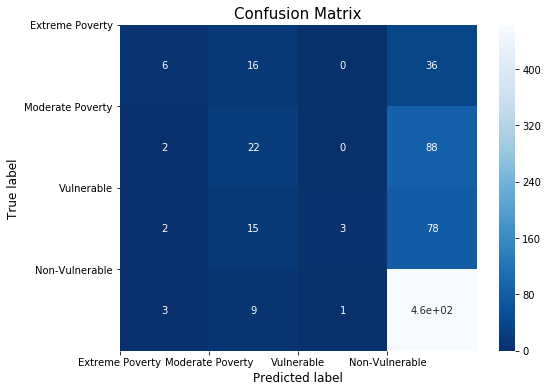

In [43]:
plot_confusion_matrix(y_test, rf_pred)

Here, I explain and interpret both the classification report and the confusion matrix:

A classification report returns three metrics of model accuracy: the precision (the number of true positives divided by all the positive predictions), the recall (the number of true positives divided by all of the actual positives), and the F1-Macro score which I described earlier. As shown above, the precision is decent with respect to those in extreme poverty as well as those in the Non-Vulnerable category, though it is not doing so well for groups 2 and 3. Recall,  in contrast, is showing that this model captures less than 15% of those in the poorest class. I'll describe why this may be the case in the next section.

The confusion matrix shows the predictions made in contrast with the true categories in which observations belong. Simply, the rows are the true classes, and the columns are the predictions. Cell 0,0 displays the number of the 0th class that the model got right, and so on. Were every prediction correct, every number not on the diagonal would be a zero. Values above the diagonal are the false positives, and values below it are false negatives. 

In general, it looks like the model learned little more than to predict that most of the classes are not in any kind of poverty as, statistically, this prediction is right most of the time. As I showed earlier, there was significant imbalance between classes of income and that's probably what's coming into play here. Fortunately, I have a number of tools to deal with this and I'll go over these in the following sections.

## Workarounds for Imbalanced Data

In practice, imbalanced data is a big problem in analysis, and this data happens to be pretty imbalanced as well. Comparatively speaking, only a small fraction of observations in the entire dataset were in poverty at all, so the model had a hard time predicting them accurately. Consider it this way: if 99% of the people in the dataset were not in poverty, all the model would really have to do is predict that everyone was *not* in poverty. In that case, the model would still technically be 99% accurate but it would be missing a lot of information in the data. Furthermore, in predictions where we don't know beforehand who actually is in poverty and who isn't, we wouldn't know who needed help. 

In the rest of this section, I describe and implement two basic workarounds for this problem: weighting, and oversampling.

### Data Weighting

Sometimes, using weights in modeling allows the model to learn with better information, such as which classes should be weighted more heavily during model training and prediction. Generally, the "weight" that is added to a single observation is something like the inverse of the probability that it is in the data. For implementation here, I'll add weights that, simply speaking, put more emphasis on predicting the lower income groups, and less on the higher ones. 

In [44]:
weights = {1:4, 2:1, 3:1.2, 4:.25}
RandF_weighted = RandomForestClassifier(n_estimators = 300, 
                                        min_samples_split = 4, 
                                        min_samples_leaf = 2, 
                                        max_features = 20, 
                                        max_depth = 9, 
                                        criterion = 'gini', 
                                        bootstrap = True)
RandF_weighted.fit(x_train, y_train)
RandF_weighted_pred = RandF_weighted.predict(x_test)
RandF_weighted_report = classification_report(y_test, RandF_weighted_pred)

#Renders Model Report, Compares to Weighted Model
print('Original Random Forest Report \n')
print(rf_report)
print('Weighted Random Forest Report \n')
print(RandF_weighted_report)

Original Random Forest Report 

              precision    recall  f1-score   support

           1       0.46      0.10      0.17        58
           2       0.35      0.20      0.25       112
           3       0.75      0.03      0.06        98
           4       0.70      0.97      0.81       476

   micro avg       0.66      0.66      0.66       744
   macro avg       0.57      0.33      0.32       744
weighted avg       0.63      0.66      0.58       744

Weighted Random Forest Report 

              precision    recall  f1-score   support

           1       0.46      0.10      0.17        58
           2       0.33      0.20      0.25       112
           3       0.50      0.03      0.06        98
           4       0.70      0.96      0.81       476

   micro avg       0.66      0.66      0.66       744
   macro avg       0.50      0.32      0.32       744
weighted avg       0.60      0.66      0.58       744



It looks like after using this method, my model was slightly better able to predict those in extreme poverty. This is what I was aiming for in this trial of model improvement. In practice, it is probably most important to know foremost who needs the most help, and not worry as much about those who aren't vulnerable anyway.

### Data Oversampling

Oversampling is another way that I'll deal with imbalances in the data. Simply put, it randomly creates synthetic data specifically from our underrepresented classes so our model has more data to learn from. This is done by creating new data wherein each poverty class is equally represented, and then having the model learn from this data instead.

In [45]:
#Creates New Training Sets with Oversampled Data
train_overs = RandomOverSampler(random_state=0)
x_resampled, y_resampled = train_overs.fit_resample(x_train, y_train)

To illustrate what resampled (oversampled) data looks like, I'll show the distribution of the new data:

([<matplotlib.axis.XTick at 0x7f9d15433a90>,
 <a list of 4 Text xticklabel objects>)

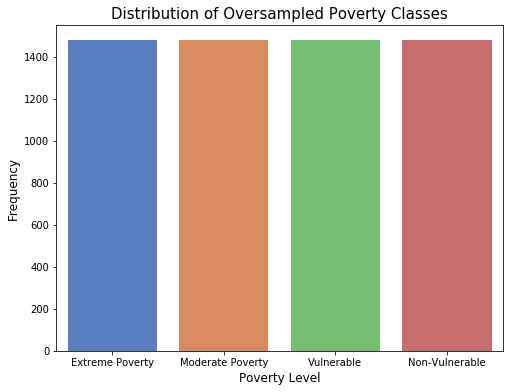

In [46]:
#Graphs resampled data
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y_resampled)
plt.title('Distribution of Oversampled Poverty Classes', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty', 'Moderate Poverty', 'Vulnerable', 'Non-Vulnerable'])

As you can see, the data distribution is now almost perfectly even. This makes it much easier for the model to make predictions of who might fall into each category. This is similar to weighting, but it gives each class the same amount of weight, meaning it's being rewarded (or penalized) for making correct predictions in any income class.

Let's see if the model performs any better on this oversampled data:

In [47]:
print('Original Classification Report \n')
print(rf_report)
RandF_resampled = RandF
RandF_resampled.fit(x_resampled, y_resampled)
RandF_resampled_pred = RandF_resampled.predict(x_test)
RandF_resampled_report = classification_report(y_test, RandF_resampled_pred)
print('Oversampled Data Classification Report \n')
print(RandF_resampled_report)

Original Classification Report 

              precision    recall  f1-score   support

           1       0.46      0.10      0.17        58
           2       0.35      0.20      0.25       112
           3       0.75      0.03      0.06        98
           4       0.70      0.97      0.81       476

   micro avg       0.66      0.66      0.66       744
   macro avg       0.57      0.33      0.32       744
weighted avg       0.63      0.66      0.58       744

Oversampled Data Classification Report 

              precision    recall  f1-score   support

           1       0.33      0.38      0.35        58
           2       0.29      0.38      0.33       112
           3       0.23      0.32      0.27        98
           4       0.88      0.74      0.80       476

   micro avg       0.60      0.60      0.60       744
   macro avg       0.43      0.45      0.44       744
weighted avg       0.66      0.60      0.63       744



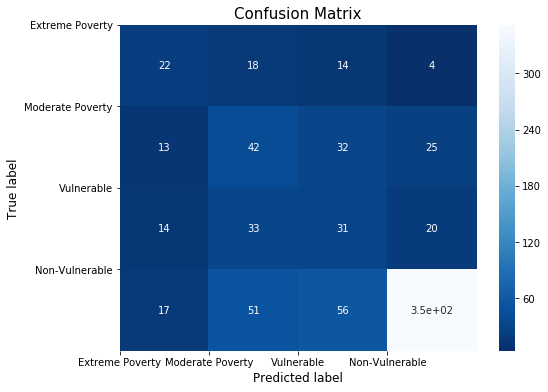

In [48]:
plot_confusion_matrix(y_test, RandF_resampled_pred)

Overall, and specifically for the lowest income level, the F-1 score has improved greatly. The model also did about as well or only a little better for the less vulnerable groups so that's good. 

The oversampled model's recall scores went up significantly (it did better at correctly finding the poor people) though it's precision scores dropped a bit (it had a few more false positives). It appears there is some tradeoff between precision and recall and the improvement of the F-1 score may mask this fact. Looks like care should be taken when deciding which metric (precision or recall) to maximize.

I'll also have a look at the "feature importances" of the model. These can be thought of as important variables, except in using a Random Forest, we call them features and feature importances instead... I'll be looking at a couple main things: what features mattered the most, and if any of the features I created are among those important features. It would be nice to know if the feature engineering stages I went through were of any help to the model.

In [49]:
#Feature Importances Dataset
feature_importances = pd.DataFrame(columns = ['Variable', 'Coef'])
feature_importances['Variable'] = list(x)
feature_importances['Coef'] = abs(RandF_resampled.feature_importances_)
feature_importances.sort_values(by = 'Coef', ascending = False, inplace = True)
feature_importances = feature_importances[0:10]

Text(0.5, 1.0, 'Most Important Features in Oversampled Model')

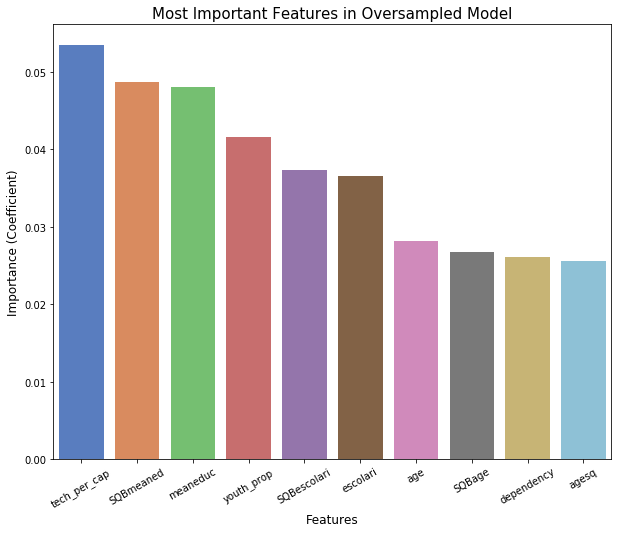

In [50]:
#Bar Chart of Top 10 Features of the Model
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances['Variable'], y = feature_importances['Coef'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance (Coefficient)', fontsize=12)
plt.xticks(rotation = 30)
plt.title('Most Important Features in Oversampled Model', fontsize=15)

Here are a few notes on this graph:

Generally speaking, this graph shows the features of the data that were the best predictors of variation in the poverty (income) level. As we might expect, general education is very important in predicting this kind of thing, as are years of school. Other age-related demographics of the household seemed to matter quite a bit. House Quality is missing here, but it might still be in the top 15 or top 20 features.

Also, it appears that a few of the variables I engineered (Tech Per Capita as well as Youth Proportion) showed up in the important features graph. Nice! Were the competition still open, I would be very excited to report my findings to scholars and/or government officials who were interested in my research.

## Conclusion and Implications

Here, I recap the process I went through, the substantive takeaways of the analysis, and a few other thoughts.

As I have shown, I visualized the data first to get an idea of what features in the data might matter most. I specifically wanted to do this on just the training data because I wanted to think about relationships that would be generalizeable to data that I hadn't seen before. I then combined the data, cleaned it, did some feature engineering that was mostly informed by the features and relationships I initially saw, and ran a few prediction models. None of them did super well, but I was able to take the one that did the best and helped it do a little bit better with some basic hyperparameter tuning, and ran the model with weights and oversampled data. 

In practice, I might have still been a bit concerned about how bad the model did at predicting those the most vulnerable to poverty. It was interesting to think that model improvements, even if marginal, could really be life-saving in this case. The biggest thing I saw that played into the model's failure to predict poverty levels was lack of data - not of the number of observations, per se, but the data that was collected on each household or person. It seems that future data collection might be improved by finding things like specific region, job type, details about the household's greater social network, and so on.

Not only was this a good domain-related experience that taught me about how I would make a classification model for poverty, but it was a good practical experience with thinking through the general problems of classification and prediction.